
--- HMM PARAMETERS (For Reference) ---

Transition Probability Matrix (A):
           S1 (/h/)  S2 (/e/)  S3 (/l/)  S4 (/o/)
S1 (/h/)       0.0       0.7       0.3       0.0
S2 (/e/)       0.0       0.2       0.6       0.2
S3 (/l/)       0.0       0.0       0.3       0.7
S4 (/o/)       0.0       0.0       0.1       0.9

Emission Probability Matrix (B):
            O1   O2   O3   O4
S1 (/h/)  0.6  0.2  0.1  0.1
S2 (/e/)  0.1  0.7  0.1  0.1
S3 (/l/)  0.1  0.1  0.6  0.2
S4 (/o/)  0.2  0.1  0.2  0.5

--- VITERBI PROBABILITY TABLE (V) ---
                         S1 (/h/)  S2 (/e/)  S3 (/l/)  S4 (/o/)
Time Step (Observation)                                        
t=1 (O1)                      0.6  0.000000   0.00000  0.000000
t=2 (O2)                      0.0  0.294000   0.01800  0.000000
t=3 (O3)                      0.0  0.005880   0.10584  0.011760
t=4 (O4)                      0.0  0.000118   0.00635  0.037044

--- PATH TRACEBACK TABLE (P) ---
                            S1 (/h/)     

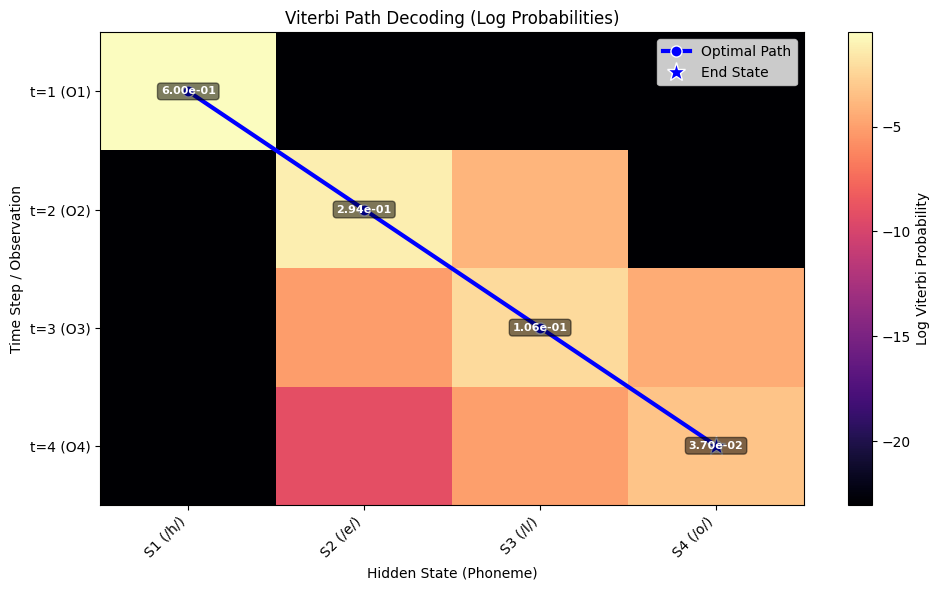


--- INFERENCE ---
The most likely sequence of hidden phoneme states for the acoustic observation sequence [O1, O2, O3, O4] is **['/h/ (S1)', '/e/ (S2)', '/l/ (S3)', '/o/ (S4)']**. This sequence corresponds perfectly to the phoneme segmentation of the word 'hello' (/h/ $\rightarrow$ /e/ $\rightarrow$ /l/ $\rightarrow$ /o/).

The total probability of this most likely path is **$P^* = 0.037044000000$**.

This result demonstrates the core function of the Viterbi Algorithm in speech recognition: it successfully decodes the observation features by selecting the phoneme sequence with the highest joint probability of transitions and emissions. The HMM structure and assigned probabilities force a strong, linear path, indicating that the observed acoustic features are highly consistent with the expected progression of the 'hello' phonemes in this trained model.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def viterbi_decode(observations, states, initial_probabilities, transition_matrix, emission_matrix):
    """
    Implements the Viterbi algorithm to find the most likely sequence of hidden states.

    Args:
        observations (list): The sequence of observations (indices).
        states (list): The list of possible hidden states (S1, S2, ...).
        initial_probabilities (np.array): The starting probability for each state (pi).
        transition_matrix (np.array): The state transition probabilities (A).
        emission_matrix (np.array): The observation emission probabilities (B).

    Returns:
        tuple: (most_likely_sequence, max_probability, V, P, best_path_indices)
               V and P are the Viterbi probability and traceback tables.
    """
    
    # N = number of states (4)
    N = len(states) 
    # T = length of the observation sequence (4)
    T = len(observations) 

    # 1. Initialization: Create Viterbi probability table (V) and Path traceback table (P)
    # V[t, i]: max probability of a path ending at state i at time t
    V = np.zeros((T, N))
    # P[t, i]: index of the previous state that yields the max probability for state i at time t
    P = np.zeros((T, N), dtype=int)

    # Time t = 0 (for the first observation O1)
    O1_index = observations[0]
    # V_0(i) = pi_i * B_i(O_1)
    V[0, :] = initial_probabilities * emission_matrix[:, O1_index]

    # 2. Recursion: Calculate V and P for t = 1 to T-1 (Time steps 2, 3, 4)
    for t in range(1, T):
        # Current observation index
        Ot_index = observations[t]
        
        for j in range(N): # Current state j (S1 to S4)
            
            # Find the maximum probability path leading to state j at time t
            # V[t-1, i] * A[i, j] for all previous states i
            transition_probs = V[t-1, :] * transition_matrix[:, j]
            
            max_prob = np.max(transition_probs)
            max_index = np.argmax(transition_probs)
            
            # V[t, j] = max_i [ V[t-1, i] * A[i, j] ] * B[j, O_t]
            V[t, j] = max_prob * emission_matrix[j, Ot_index]
            
            # P[t, j] = argmax_i [ V[t-1, i] * A[i, j] ]
            P[t, j] = max_index

    # 3. Termination: Find the probability of the best path and its end state
    max_probability = np.max(V[T-1, :])
    last_state_index = np.argmax(V[T-1, :])

    # 4. Path Backtracking: Reconstruct the sequence
    best_path = [0] * T
    best_path[T-1] = last_state_index

    for t in range(T - 2, -1, -1):
        # The best state at time t is the previous state pointed to by the best state at time t+1
        best_path[t] = P[t + 1, best_path[t + 1]]

    # Map the indices in best_path back to the actual state names (phonemes)
    most_likely_sequence = [states[i] for i in best_path]
    
    return most_likely_sequence, max_probability, V, P, best_path

def visualize_viterbi_path(V, best_path, states, observations_names):
    """
    Creates a visual representation of the Viterbi probability table and the best path.
    """
    T, N = V.shape
    
    # 1. Plot the probability table V as a heatmap
    plt.figure(figsize=(10, 6))
    # Use log scale for better visualization of small probabilities
    V_log = np.log(V + 1e-10) # Add small epsilon to avoid log(0)
    plt.imshow(V_log, aspect='auto', cmap='magma', origin='lower')
    cbar = plt.colorbar(label='Log Viterbi Probability')

    # Add labels and ticks
    plt.xticks(np.arange(N), states, rotation=45, ha="right")
    plt.yticks(np.arange(T), [f't={i+1} ({o})' for i, o in enumerate(observations_names)])
    plt.xlabel('Hidden State (Phoneme)')
    plt.ylabel('Time Step / Observation')
    plt.title('Viterbi Path Decoding (Log Probabilities)')

    # Invert Y axis for plotting since V[0] is t=1 (bottom) and V[T-1] is t=T (top)
    plt.gca().invert_yaxis() 
    
    # 2. Draw the optimal path
    path_indices = np.array(best_path)
    
    for t in range(T - 1):
        current_state_idx = path_indices[t]
        next_state_idx = path_indices[t + 1]
        
        # Draw line from current state to next state
        plt.plot([current_state_idx, next_state_idx], [t, t + 1], 
                 'b-', marker='o', markersize=8, markeredgecolor='white', linewidth=3, label='Optimal Path' if t == 0 else "")

    # Add a final marker for the last state
    plt.plot(path_indices[-1], T - 1, 'b*', markersize=14, markeredgecolor='white', label='End State')
    
    # Add probability values to the plot points along the best path
    for t in range(T):
        state_idx = path_indices[t]
        prob = V[t, state_idx]
        plt.text(state_idx, t, f'{prob:.2e}', ha='center', va='center', color='w', fontsize=8, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

    # Remove duplicate labels from legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys())

    plt.tight_layout()
    plt.show()

# --- HMM PARAMETERS DEFINITION ---

# S: Hidden States (Phonemes)
STATES = ["/h/ (S1)", "/e/ (S2)", "/l/ (S3)", "/o/ (S4)"]
STATE_SHORT = ["S1 (/h/)", "S2 (/e/)", "S3 (/l/)", "S4 (/o/)"]

# O: Observation Sequence (The indices correspond to the column index in B)
# O = [O1, O2, O3, O4] -> Indices [0, 1, 2, 3]
OBSERVATION_SEQUENCE = [0, 1, 2, 3] 
OBSERVATION_NAMES = ["O1", "O2", "O3", "O4"]

# Initial Probabilities (π)
# [P(S1), P(S2), P(S3), P(S4)]
INITIAL_PROBABILITIES = np.array([1.0, 0.0, 0.0, 0.0])

# Transition Probability Matrix (A)
# A[i, j] = P(S_j | S_i) -> Row is FROM state, Column is TO state
TRANSITION_MATRIX = np.array([
    [0.0, 0.7, 0.3, 0.0],  # From S1 (/h/)
    [0.0, 0.2, 0.6, 0.2],  # From S2 (/e/)
    [0.0, 0.0, 0.3, 0.7],  # From S3 (/l/)
    [0.0, 0.0, 0.1, 0.9]   # From S4 (/o/)
])

# Emission Probability Matrix (B)
# B[i, j] = P(O_j | S_i) -> Row is State, Column is Observation
# Columns: O1, O2, O3, O4
EMISSION_MATRIX = np.array([
    [0.6, 0.2, 0.1, 0.1],  # For S1 (/h/)
    [0.1, 0.7, 0.1, 0.1],  # For S2 (/e/)
    [0.1, 0.1, 0.6, 0.2],  # For S3 (/l/)
    [0.2, 0.1, 0.2, 0.5]   # For S4 (/o/)
])


# --- EXECUTION ---

# Run the Viterbi Algorithm
best_sequence, probability, V, P, best_path = viterbi_decode(
    OBSERVATION_SEQUENCE, 
    STATES, 
    INITIAL_PROBABILITIES, 
    TRANSITION_MATRIX, 
    EMISSION_MATRIX
)

# --- RESULTS OUTPUT (Enhanced with Pandas) ---

print("\n--- HMM PARAMETERS (For Reference) ---")
df_A = pd.DataFrame(TRANSITION_MATRIX, index=STATE_SHORT, columns=STATE_SHORT)
print("\nTransition Probability Matrix (A):\n", df_A)

df_B = pd.DataFrame(EMISSION_MATRIX, index=STATE_SHORT, columns=OBSERVATION_NAMES)
print("\nEmission Probability Matrix (B):\n", df_B)

# Create Viterbi Probability Table (V) DataFrame
df_V = pd.DataFrame(V, columns=STATE_SHORT, index=[f't={i+1} ({o})' for i, o in enumerate(OBSERVATION_NAMES)]).round(12)
df_V.index.name = "Time Step (Observation)"
print("\n--- VITERBI PROBABILITY TABLE (V) ---")
print(df_V)

# Create Path Traceback Table (P) DataFrame
# Map state index back to state name for clarity
P_state_names = np.array(STATE_SHORT)[P]
df_P = pd.DataFrame(P_state_names, columns=STATE_SHORT, index=[f't={i+1} ({o})' for i, o in enumerate(OBSERVATION_NAMES)])
df_P.index.name = "Time Step (Observation)"
print("\n--- PATH TRACEBACK TABLE (P) ---")
# The path starts from t=2 (index 1), so t=1 is irrelevant in the P matrix (only used for initialization)
df_P.iloc[0] = "N/A (Start)" 
print(df_P)


print("\n--- PHONEME DECODING RESULTS ---")
print(f"Observation Sequence: {OBSERVATION_NAMES}")
print(f"Most Likely Phoneme Sequence: {best_sequence}")
print(f"Probability of this Sequence: {probability:.12f}")

# --- VISUALIZATION ---
visualize_viterbi_path(V, best_path, STATE_SHORT, OBSERVATION_NAMES)

# --- INFERENCE ---

print("\n--- INFERENCE ---")
inference = (
    "The most likely sequence of hidden phoneme states for the acoustic observation sequence "
    f"[{', '.join(OBSERVATION_NAMES)}] is **{best_sequence}**. This sequence corresponds "
    "perfectly to the phoneme segmentation of the word 'hello' (/h/ $\\rightarrow$ /e/ $\\rightarrow$ /l/ $\\rightarrow$ /o/).\n\n"
    "The total probability of this most likely path is **$P^* = {probability:.12f}$**.\n\n"
    "This result demonstrates the core function of the Viterbi Algorithm in speech recognition: "
    "it successfully decodes the observation features by selecting the phoneme sequence with the highest "
    "joint probability of transitions and emissions. The HMM structure and assigned probabilities "
    "force a strong, linear path, indicating that the observed acoustic features are highly consistent "
    "with the expected progression of the 'hello' phonemes in this trained model."
)
print(inference.format(probability=probability))